<div style="color:#483D8B;text-align:center">
  <h1> T-tests and Analysis of Variance (ANOVA) </h1>
  <h3> Ryan Gust </h3>
  <h4> Updated: 2019-01-10 </h4>
</div>

## Overview

This notebook will analyze a fabricated dataset representing race and age of voters.

Tests used will include one-way ANOVA test, paired t-test, and Tukey's Range Test, starting with a baseline comparison before altering the data and moving on to the post hoc analyses.

#### Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Data

The data used in this notebook is randomly generated, following the procedures outlined in [this blog post](http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-16_23.html) with minor alterations for segmentation purposes.

In [2]:
# Set a random state variable and assign it to scipy's random state
ss.poisson.random_state = rand = np.random.RandomState(404)

In [3]:
# Generate random data selected from a weighted distribution
races = ["asian", "black", "hispanic", "other", "white"]
voter_race = rand.choice(a=races, p=[0.05, 0.15, 0.25, 0.05, 0.5], size=1000)

In [4]:
voter_age = ss.poisson.rvs(loc=18, mu=30, size=1000)
white_ages = ss.poisson.rvs(loc=18, mu=32, size=1000) # increase the mean age of white voters

age_shift = np.where(voter_race=="white", white_ages, voter_age) # Swap in altered white ages

## Exploratory Data Analysis

The data used in this notebook attempts to mock a racial distribution of a voter population sample. As it is artificially generated, no preprocessing is required. 

In [5]:
# Group age data by race
voters = pd.DataFrame({"race":voter_race, "age":voter_age})
groups = voters.groupby("race").groups

# Perform the ANOVA
ss.f_oneway(*[voter_age[v] for v in groups.values()])

F_onewayResult(statistic=0.26737204976027656, pvalue=0.8990043212082999)

With a F-statistic of 0.2673 and a p-value of 0.899, the one-way ANOVA test provides a strong evidence that there is not a significant difference between means of each group. Since the data was all pulled from the same mock distribution, this is exactly what we would expect to see. 

### Modify Distribution and Reanalyze

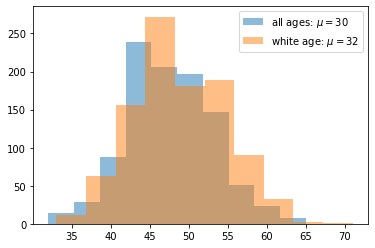

In [6]:
plt.hist(voter_age, alpha=0.5, label='all ages: $\mu=30$')
plt.hist(age_shift, alpha=0.5, label='white age: $\mu=32$')
plt.legend()
plt.show()

Now, we will be performing the same test on the modified dataset. Visually, we can already see how increasing the mean age of white voters effects the distribution. 

In [7]:
# Group age data by race
voters_shift = pd.DataFrame({"race":voter_race, "age":age_shift})
groups_shift = voters_shift.groupby("race").groups   

# Perform the ANOVA
ss.f_oneway(*[age_shift[v] for v in groups_shift.values()])

F_onewayResult(statistic=13.550717021659178, pvalue=9.24549061364278e-11)

After the change, the F-statistic is 13.55 and the p-value is 9.245e-11<br>
A p-value of this size is many orders of magnitude smaller than p=0.05, a commonly used significance level.  This serves as a very strong indication that there are indeed differences between the groups. 

An **F-statistic** in the simplest sense is just the ratio of two variances. Building on this, an **F-test** is used for assessing whether the statistic follows an F-distribution under the null hypothesis. <br>
A **one-way ANOVA test** uses F-tests as means to determine whether variance is due to differences _within_ groups of data or differences _between_ the groups. Put another way, a one-way ANOVA test assess whether variance between two or more (typically three or more) sample means is statistically significant. 

In [8]:
# Get all unique racial pairings
race_pairs = [(races[r1], races[r2]) for r1 in range(4) for r2 in range(r1+1,5)]

In [9]:
# Conduct t-test on each pair for the altered data
for race1, race2 in race_pairs: 
    print(race1, race2,'\t:', ss.ttest_ind(age_shift[groups_shift[race1]], age_shift[groups_shift[race2]])) 

asian black 	: Ttest_indResult(statistic=0.5081230371721365, pvalue=0.6119242403088412)
asian hispanic 	: Ttest_indResult(statistic=0.6204493257066322, pvalue=0.5354223107249675)
asian other 	: Ttest_indResult(statistic=0.8804714769956019, pvalue=0.38034939855706185)
asian white 	: Ttest_indResult(statistic=-2.6589616806422485, pvalue=0.008072090696940136)
black hispanic 	: Ttest_indResult(statistic=0.12543582439538467, pvalue=0.9002425060815309)
black other 	: Ttest_indResult(statistic=0.6237279268453277, pvalue=0.5334896890146905)
black white 	: Ttest_indResult(statistic=-4.852584065988863, pvalue=1.5413623060362876e-06)
hispanic other 	: Ttest_indResult(statistic=0.5585844610829792, pvalue=0.5768434528987283)
hispanic white 	: Ttest_indResult(statistic=-6.0120762205487575, pvalue=2.89291138112763e-09)
other white 	: Ttest_indResult(statistic=-4.130139676281511, pvalue=4.195825609847373e-05)


In [10]:
# print the most likely candidates based on p-value and significance level
for race1, race2 in race_pairs:
    siglvl = 0.05
    result = ss.ttest_ind(age_shift[groups_shift[race1]], age_shift[groups_shift[race2]])
    if result.pvalue < siglvl:
        print(race1, race2,'\t:',result) 

asian white 	: Ttest_indResult(statistic=-2.6589616806422485, pvalue=0.008072090696940136)
black white 	: Ttest_indResult(statistic=-4.852584065988863, pvalue=1.5413623060362876e-06)
hispanic white 	: Ttest_indResult(statistic=-6.0120762205487575, pvalue=2.89291138112763e-09)
other white 	: Ttest_indResult(statistic=-4.130139676281511, pvalue=4.195825609847373e-05)


With the one-way ANOVA test indicating a significant between groups did exist, conducting a pairwise t-test on each group pairing allows us to hone in on which group(s) stands out. 

The p-values should be taken with a grain of salt, however, since as you increase the number of comparisons made, you as well introduce more opportunities for random chance to play a large factor. One of the simplest ways to address this is issue is with a [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction). <br>
A **Bonferroni correction** addresses the [Multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) by simply dividing the starting significance level (e.g. p=0.05) by the number of comparisons made (in this case 10).



group1,group2,meandiff,lower,upper,reject
asian,black,-0.4483,-2.8332,1.9367,False
asian,hispanic,-0.5205,-2.757,1.7159,False
asian,other,-0.9576,-3.7303,1.8152,False
asian,white,2.0986,-0.0352,4.2323,False
black,hispanic,-0.0723,-1.6735,1.529,False
black,other,-0.5093,-2.8007,1.7821,False
black,white,2.5468,1.0925,4.0012,True
hispanic,other,-0.437,-2.5734,1.6994,False
hispanic,white,2.6191,1.4238,3.8144,True
other,white,3.0561,1.0275,5.0847,True


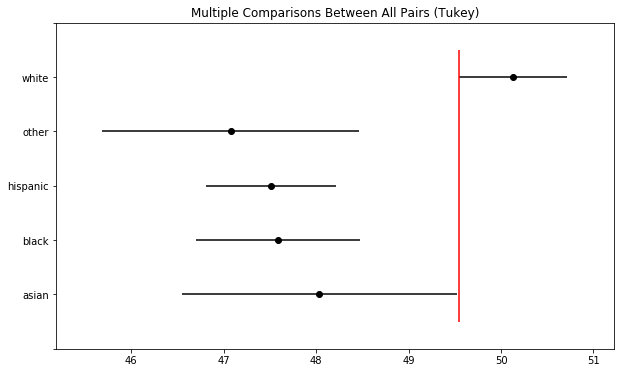

In [11]:
# endog = data, alpha = Significance level
tukey2 = pairwise_tukeyhsd(endog=age_shift, groups=voter_race, alpha=0.05)  

tukey2.plot_simultaneous() # Plot group confidence intervals
plt.vlines(x=49.55, ymin=-0.5, ymax=4.5, color="red")

tukey2.summary()

**Tukey's test** is more exacting in the way that it approaches the Multiple comparisons problem. Rather than conducting pairwise t-tests and adjusting the significance level to compensate, Tukey's test, in effect, combines t-tests with an adjustment made to correct for the [family-wise error rate](https://en.wikipedia.org/wiki/Family-wise_error_rate).

Tukey's test is not the most precise for all cases but works quite well when confidence intervals are needed or sample sizes are unequal.

https://en.wikipedia.org/wiki/Tukey%27s_range_test

## Conclusions

This note demonstrated the use of: 
* one-way ANOVA test 
* pairwise t-tests 
* Tukey's range test

on a generated dataset representing fictitious voter demographics.

Future works could involve the use of a real vote demographic dataset, as opposed to a mocked up one, exploring other methods of dealing with the multiple comparison problem (e.g. [Scheffé's method](https://en.wikipedia.org/wiki/Scheff%C3%A9%27s_method), [Newman–Keuls method](https://en.wikipedia.org/wiki/Newman%E2%80%93Keuls_method)), and potentially using other variants of ANOVA tests. 

### References

#### Text:

1. http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-16_23.html
2. http://statisticsbyjim.com/anova/f-tests-anova/ 
3. https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/f-statistic-value-test/#FandP
4. http://blog.minitab.com/blog/adventures-in-statistics-2/understanding-analysis-of-variance-anova-and-the-f-test
5. https://en.wikipedia.org/wiki/One-way_analysis_of_variance
6. https://en.wikipedia.org/wiki/F-test

#### Code:
1. http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-16_23.html